<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d1_path_fix/tutorials/W2D1_CNNsRNNs/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 2, Day 1, Tutorial 3
# Day 1: Parameter Sharing (CNNs and RNNs)

__Content creators:__ Alona Fyshe, Dawn McKnight, Richard Gerum, Cassidy Pirlot, Rohan Saha, Liam Peet-Pare, Saeed Najafi 

__Content reviewers:__ Saeed Salehi, Lily Cheng, Yu-Fang Yang, Polina Turishcheva

__Production editors:__ Anmol Gupta, Spiros Chavlis 

__Based on material from:__ Konrad Kording, Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- Understand the structure of a Recurrent Neural Network (RNN)
- Build a simple RNN model

 

In [8]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML

HTML('<iframe src="https://docs.google.com/presentation/d/1jrKnXGoCXovB5pMGtnsF0ICxr1Cu_vDk/edit#slide=id.p1" frameborder="100" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

In [9]:
#@title Dependencies
!pip install livelossplot --quiet

In [10]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from tqdm.notebook import tqdm, trange
from time import sleep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

!mkdir images
!wget "https://raw.githubusercontent.com/dem1995/generally_available_files/main/chicago_skyline_shrunk_v2.bmp"
!mv *.bmp images

mkdir: cannot create directory ‘images’: File exists
--2021-06-20 10:13:17--  https://raw.githubusercontent.com/dem1995/generally_available_files/main/chicago_skyline_shrunk_v2.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 808090 (789K) [image/bmp]
Saving to: ‘chicago_skyline_shrunk_v2.bmp’

chicago_skyline_shr 100%[===================>] 789.15K  --.-KB/s    in 0.02s   

2021-06-20 10:13:17 (38.7 MB/s) - ‘chicago_skyline_shrunk_v2.bmp’ saved [808090/808090]



In [11]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [12]:
# @title Set seed for reproducibility
seed = 2021
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

print ('Seed has been set.')

Seed has been set.


# Section 1: Recurrent Neural Networks (RNNs)

Video available at https://youtu.be/0Majex-aF0E


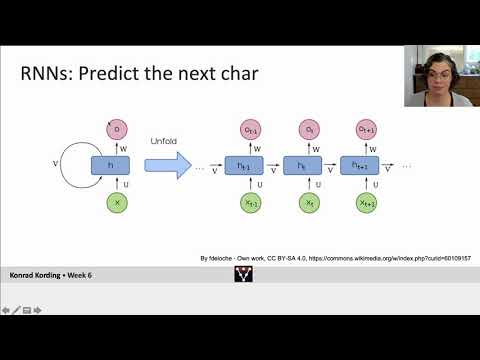

In [13]:
#@title Video 1: Intro to RNNs
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="0Majex-aF0E", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

RNNs are compact models that operate over timeseries, and have the ability to remember past input. They also save parameters by using the same weights at every time step.  If you've heard of Transformers, those models dont' have this kind of temporal weight sharing, and so they are *much* larger.

The code below is adapted from https://github.com/spro/char-rnn.pytorch

In [14]:
#@title RNN framework (run me)

!pip install unidecode

!wget --output-document=/content/sample_data/twain.txt https://github.com/amfyshe/amfyshe.github.io/blob/master/twain.txt

# https://github.com/spro/char-rnn.pytorch

import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif self.model == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))





--2021-06-20 10:13:20--  https://github.com/amfyshe/amfyshe.github.io/blob/master/twain.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/sample_data/twain.txt’

/content/sample_dat     [ <=>                ] 106.45K  --.-KB/s    in 0.006s  

2021-06-20 10:13:20 (17.9 MB/s) - ‘/content/sample_data/twain.txt’ saved [109004]



In [15]:
#@title Helpers (run me)
# https://github.com/spro/char-rnn.pytorch

import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)

    inp = prime_input[:,-1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted


In [16]:
# https://github.com/spro/char-rnn.pytorch
!ls
!pwd

batch_size = 50
chunk_len = 200
model = "rnn" # other options: lstm, gru

#hyperparams
n_layers = 2
hidden_size = 200
n_epochs = 2000
learning_rate = 0.01
print_every = 25

def train(inp, target):
  hidden = decoder.init_hidden(batch_size)
  decoder.zero_grad()
  loss = 0

  for c in range(chunk_len):
    output, hidden = decoder(inp[:,c], hidden)
    loss += criterion(output.view(batch_size, -1), target[:,c])

  loss.backward()
  decoder_optimizer.step()
  return loss.item() / chunk_len

file, file_len = read_file('/content/sample_data/twain.txt')

def random_training_set(chunk_len, batch_size):
  inp = torch.LongTensor(batch_size, chunk_len)
  target = torch.LongTensor(batch_size, chunk_len)
  for bi in range(batch_size):
    start_index = random.randint(0, file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = file[start_index:end_index]
    inp[bi] = char_tensor(chunk[:-1])
    target[bi] = char_tensor(chunk[1:])
  inp = Variable(inp)
  target = Variable(target)
  return inp, target

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adagrad(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1), position=0, leave=True):
  loss = train(*random_training_set(chunk_len, batch_size))
  loss_avg += loss

  if epoch % print_every == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    print(generate(decoder, 'Wh', 100), '\n')

images	sample_data
/content
Training for 2000 epochs...


 10s (25 1%) 2.2108]
Whhdextson" colg--bopkj-se="aspatectisk="Me" chavumy-b.git="beadarocl csionon" ter-2a-fle-menterubass= 

 20s (50 2%) 1.9526]
Whendion/urogion-menumanoumposta-shadary="1-3.75 0 4.0561.75M77.79M25 0 11.5a.75 0 00 060.77-0.5@3.5 0 

 30s (75 3%) 1.6591]
WheEJNggZkge/pppogeta    <meta <stajbed="3.44 0 00 111.75 2.5 0 00 1.5 0 11.16 8.594.036 1.75 0 08.222 

 40s (100 5%) 1.5504]
Wheckarcon/ciment&quot;: &quot;: &quot;: &quot;: &quot;: [], &quot;: &quot;, &quot;5 ed width="12="16 

 51s (125 6%) 1.5671]
Who/s-name" tyss="Bump-link--bagss="d-0 0 1.16  5 1v-2.57-.27-.25.75 0 00-1.06-.48 e.github.iot-relate 

 1s (150 7%) 1.2857]
Whoverver, intripe           </matref="toped role="Mancon rel-noneddele_tertion no-proderline" data-vi 

 11s (175 8%) 1.3612]
WhiL5 ame3.252a.75.75 0 001 0 01-1.5 0 01-.25.25 0 00 11.06l-.7012.54F-3.25a1 1.75 0 01.16 0.21-.0018  

 21s (200 10%) 1.3390]
Whex/chequithue">/></sightt-serrofer" controrue" content="true" viewBox="0 0 10-1.5 0va.792"

#Section 2: Power consumption in Deep Learning

Training NN models can be incredibly costly, both in actual money but also in power consumption. 

Video available at https://youtu.be/2upwdK3bcXU


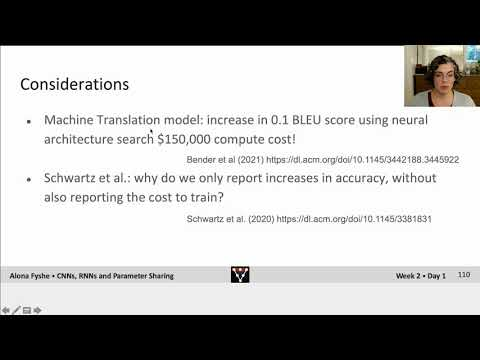

In [17]:
#@title Video 2: Carbon Footprint of AI
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2upwdK3bcXU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Take a few moments to chat with your pod about the following points:
* Which societal costs of training do you find most compelling?
* When is training an AI model worth the cost?  Who should make that decision?
* Should there be additional taxes on energy costs for compute centers? 

# Section 3: Wrap up

What a day!  We've learned a lot!  The basics of CNNs and RNNs, and how changes to architecture that allow models to parameter share can greatly reduce the size of the model.  We learned about convoliution and pooling, as well as the basic idea behind RNNs.  To wrap up we thought about the impact of training large NN models.

Video available at https://youtu.be/Ikb4hwR4pU0


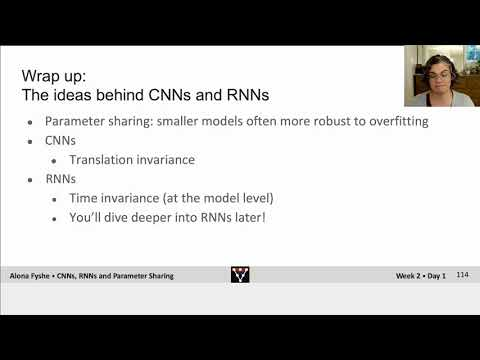

In [18]:
#@title Video 3: Wrap-up
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ikb4hwR4pU0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video